In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
import string
import contractions

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sb
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

en_model = spacy.load('en_core_web_md')

In [2]:
df = pd.read_csv('train.csv',encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

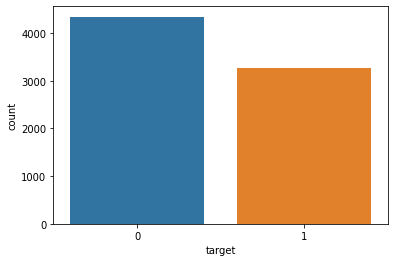

In [3]:
sb.countplot(x=df.target)

The target column is well balanced

In [4]:
# check for missing data
for col in df.columns:
    if df[col].isnull().mean()>0:
        print(col,df[col].isnull().mean())

keyword 0.008012610009194798
location 0.33272034677525286


33% data of "location" column is missing

In [5]:
# only keep 'text' and 'target' columns
df = df[['text','target']]

In [6]:
# cleaning function
def clean_text(text):
    toks = text.lower().split()
    toks = [contractions.fix(t) for t in toks if t not in string.punctuation and '#' not in t]
    toks = en_model(" ".join(toks))
    toks = [t for t in toks if str(t)!="'s"]
    toks = [t for t in toks if not t.like_url and '@' not in str(t)]
    toks = [t for t in toks if str(t).isalpha() and not t.is_stop]
    toks = [str(t) for t in toks if not t.is_oov]
    return " ".join(toks)

From the tweets, we remove stopwords, URLs, punctuations, numbers and only keep words that are not out-of-vocabulary

In [7]:
for _ in range(4):
    i = np.random.randint(0,len(df))
    print('Original : '+df.text[i]+'\nCleaned : '+clean_text(df.text[i]))
    print()

Original : @cityofhummus @ILNewsFlash do you want to hear more? Displaced my parents until both died in the diasporas !
Cleaned : want hear displaced parents died diasporas

Original : i drowned in the kiddie pool and i lost my ploppy
Cleaned : drowned kiddie pool lost

Original : @TheLegendBlue @Cozmo23 they'll probably allow us to ascend them but not get them to the damage max values
Cleaned : probably allow ascend damage max values

Original : Apollo Brown - Detonate (feat. M.O.P.) by Mello Music Group via #soundcloud https://t.co/PRojeAvG8T
Cleaned : apollo brown detonate feat mello music group t



In [8]:
# get clean text
x = df.text.apply(lambda x: clean_text(x))
y = df.target.values

# split the data in train, validation and test (75:15:10) 
xtrain,xval,ytrain,yval = train_test_split(x,y,train_size=0.75,random_state=100)
xval,xtest,yval,ytest = train_test_split(xval,yval,train_size=0.6,random_state=100)

# get max input length
maxlen = 0
for i in x:
    if len(i.split())>maxlen: maxlen=len(i.split())

In [9]:
# tokenizing and padding

tk = Tokenizer()
tk.fit_on_texts(xtrain)
seq = tk.texts_to_sequences(xtrain)
xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xval)
xval = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xtest)
xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

x_voc = len(tk.word_counts)+1

In [10]:
# load glove vectors
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
 
glove_embeddings = load_glove_model("D:/glove.6B.200d.txt")

Loading Glove Model
400000 words loaded!


In [11]:
# create pretrained embedding matrix
emb = np.zeros((x_voc,200))
for w,idx in tk.word_index.items():
    try: emb[idx] = glove_embeddings[w]
    except: pass

In [12]:
# Bahdanau (Additive) Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    
    def build(self,input_shape):
        self.W1 = tf.keras.layers.Dense(self.units)
        self.W2 = tf.keras.layers.Dense(self.units)
        self.V = tf.keras.layers.Dense(1)
    
    def get_config(self):
        config = super().get_config()
        config.update({'units':self.units})
        return config

In [13]:
# build and compile the model

inputs = Input(shape=(maxlen,))
i = Embedding(x_voc,200,weights=[emb],trainable=True)(inputs)
i,h,_ = LSTM(100,return_sequences=True,return_state=True,dropout=0.2)(i)
i,_ = Attention(100)(i,h)
i = Dense(100,activation='relu')(i)
i = BatchNormalization()(i)
i = Dropout(0.2)(i)
outputs = Dense(1,activation='sigmoid')(i)

model = Model(inputs,outputs)

rms = RMSprop(learning_rate=0.00005)

model.compile(loss='binary_crossentropy',
              optimizer=rms,
              metrics=['accuracy'])
    

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 200)      1950000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 21, 100),    120400      ['embedding[0][0]']              
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                              

In [14]:
# training at 40 epochs and saving weights with smallest val_loss

epochs=40

metrics = {'accuracy':[],'val_accuracy':[],'loss':[],'val_loss':[]}

print(f'epoch = 1/{epochs}')
model.fit(xtrain,ytrain,epochs=1,batch_size=64)
loss,acc = model.evaluate(xtrain,ytrain,verbose=0)
metrics['accuracy'].append(acc)
metrics['loss'].append(loss)
loss,acc = model.evaluate(xval,yval)
metrics['val_loss'].append(loss)
metrics['val_accuracy'].append(acc)
print()
for i in range(2,epochs+1):
    print(f'epoch = {i}/{epochs}')
    model.fit(xtrain,ytrain,epochs=1,batch_size=64)
    loss,acc = model.evaluate(xtrain,ytrain,verbose=0)
    metrics['accuracy'].append(acc)
    metrics['loss'].append(loss)
    loss,acc = model.evaluate(xval,yval)
    metrics['val_loss'].append(loss)
    metrics['val_accuracy'].append(acc)
    print()
    if loss<metrics['val_loss'][-1]: 
        model.save_weights('weights')
        best_met = met

epoch = 1/40
36/36 [==============================] - 0s 5ms/step - loss: 0.6667 - accuracy: 0.7496

epoch = 2/40
36/36 [==============================] - 0s 5ms/step - loss: 0.6338 - accuracy: 0.7828

epoch = 3/40
36/36 [==============================] - 0s 5ms/step - loss: 0.5928 - accuracy: 0.7968

epoch = 4/40
36/36 [==============================] - 0s 4ms/step - loss: 0.5423 - accuracy: 0.7960

epoch = 5/40
36/36 [==============================] - 0s 4ms/step - loss: 0.4924 - accuracy: 0.8047

epoch = 6/40
36/36 [==============================] - 0s 5ms/step - loss: 0.4522 - accuracy: 0.8030

epoch = 7/40
36/36 [==============================] - 0s 5ms/step - loss: 0.4281 - accuracy: 0.8091

epoch = 8/40
36/36 [==============================] - 0s 4ms/step - loss: 0.4147 - accuracy: 0.8179

epoch = 9/40
36/36 [==============================] - 0s 4ms/step - loss: 0.4076 - accuracy: 0.8179

epoch = 10/40
36/36 [==============================] - 0s 4ms/step - loss: 0.4043 - accurac

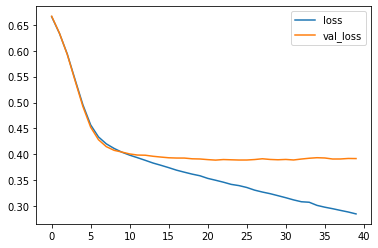

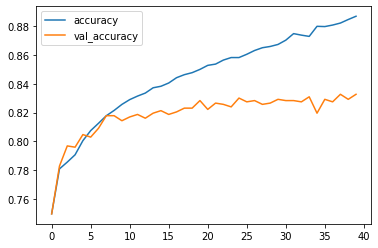

In [15]:
# visualising training and validation metrics
metrics = pd.DataFrame(metrics)
metrics[['loss','val_loss']].plot()
plt.show()
metrics[['accuracy','val_accuracy']].plot()
plt.show()

In [16]:
# load best weights
model.load_weights('weights')
model.evaluate(xval,yval) #loss and accuracy of validation data
model.evaluate(xtest,ytest) #loss and accuracy of test data

24/24 [==============================] - 0s 5ms/step - loss: 0.4381 - accuracy: 0.8097


[0.4381180703639984, 0.8097112774848938]

              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84       484
         1.0       0.70      0.84      0.76       278

    accuracy                           0.81       762
   macro avg       0.80      0.82      0.80       762
weighted avg       0.82      0.81      0.81       762



<AxesSubplot:>

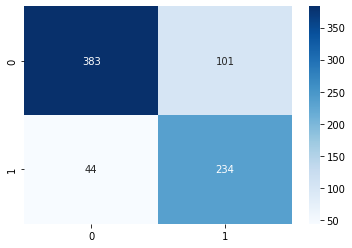

In [17]:
# get classification report and confusion matrix

pred = np.round(model.predict(xtest)).flatten()
print(classification_report(pred,ytest))
sb.heatmap(confusion_matrix(pred,ytest),annot=True,fmt='d',cmap='Blues')

In [18]:
# submission

test = pd.read_csv('test.csv',encoding='utf-8')
test = test[['id','text']]
x_sub = test.text.apply(lambda x: clean_text(x))

seq = tk.texts_to_sequences(x_sub)
x_sub = pad_sequences(seq,maxlen=maxlen,padding='post')

pred = np.round(model.predict(x_sub)).flatten()

test['target'] = pred
test.target = test.target.apply(lambda x: int(x))

test[['id','target']].to_csv('submission.csv',index=False)